Import libraries

In [1]:
import numpy as np
import time
import h5py
import scipy
import copy
from numba import jit

Import PyTTN dependencies

In [2]:
from pyttn import *
from pyttn.utils import orthopol_discretisation
from pyttn.utils import visualise_tree

import sys
sys.path.append("../examples/old/spin_boson_model/")
from chain_map import chain_map

## Bath discretisation

The spectral density of the continuous bath is given by: 
$
J(\omega) = \text{sign}(\omega) \frac{\pi}{2}\alpha\omega_c \left(\frac{\omega}{\omega_c}\right)^s e^{-|\omega/\omega_c|}
$.

To obtain the bath spectral function, it is necessary to consider the effect of the Bose distribution at finite temperature:

- At zero temperature, $S(\omega) = J(\omega) \quad \forall \, \omega > 0$

- At finite temperature, $S(\omega) = \frac{1}{2} J(\omega) \left( 1 + \frac{1}{\text{tanh}(\frac{\beta \omega}{2})} \right)$

The bath spectral function is discretised following an Orthogonal polynomial discretisation strategy (see [PRB 92, 155126 (2015)](https://journals.aps.org/prb/pdf/10.1103/PhysRevB.92.155126) for reference), which calculates the copulings and on-site terms for a discrete bath in a star configuration.

The maximum frequency cutoff of the discretisation is set by $\omega_{max}=$ `Nw`*$\omega_c$.
The effect of modes with frequency $\omega_i > \omega_{max}$ is approximated by performing a polaron transformation for these modes, and tracing them out in the resulting Hamiltonian. This gives rise to a renormalisation term `renorm` of the tunnelling matrix element $\Delta$, which will be important later on when the Hamiltonian is initialised.

A consequence of the Bose distribution is that, at finite temperature, $S(\omega)$ will be non-zero for negative frequencies, as expected from thermo-field theory.

The function below discretises the bath in a star configuration. Its parameters are `Nb`, the number of bath modes; and `alpha`, `wc` and `s`, parameters of the spectral density. As optional parameters, one can specify `beta`, the inverse temperature; `Nw`, the parameter that sets maximum cutoff frequency; `atol`, the absolute tolerance of the discretisation; and `rtol`, the relative tolerance of the discretisation.

The function returns `w`, the on-site frequencies $\omega$ of boson bath; 
`g`, the couplings $g$ of the bosons to TLS; and
`renorm`, the renormalisation constant.

In [18]:
def discretise_bath(Nb, alpha, wc, s, beta = None, Nw = 10, moment_scaling=2, atol=0, rtol=1e-10):
    
    # Exponential cutoff spectral density
    @jit(nopython=True)
    def J(w):
        return np.abs(np.pi/2*alpha*wc*np.power(w/wc, s)*np.exp(-np.abs(w/wc)))*np.where(w > 0, 1.0, -1.0)

    # Frequency-dependent bath spectral function
    @jit(nopython=True)
    def S(w):
        # At zero temperature
        if beta == None:
            return J(w)*np.where(w > 0, 1.0, 0.0)
        
        # At finite temperature
        else:
            return J(w)*0.5*(1.0+1.0/np.tanh(beta*w/2.0))

    # Set maximum cutoff frequency
    wmax = Nw*wc

    # Set minimum frequency: 0 at zero temperature, negative at finite temperature
    wmin = 0
    if beta != None:
        wmin = -wmax/(beta*wc+1)

    # Discretise the bath using the orthopol discretisation strategy
    g, w = orthopol_discretisation.discretise(lambda x : S(x), wmin, wmax, Nb, moment_scaling=moment_scaling, atol=atol, rtol=rtol)

    # Compute the polaron-transformed renormalisation of the truncated high frequency modes
    renorm = np.exp(-2.0/np.pi*scipy.integrate.quad(lambda x : J(x)/(x*x), wmax, np.inf)[0])

    return np.array(g), np.array(w), renorm

## Hamiltonian preparation

This section prepares the Hamiltonian as a `SOP object` (which stands for _"Sum of OPerators"_)
that later will be converted into a Tree Tensor Network Operator (a TTNO). 

Each of the site operators in the Hamiltonian is initialised as a `sOP object` (which stands for _"site OPerator"_). The first parameter of `sOP()` specifies the kind of operator, and the second parameter indicates the site index where the operator acts on.

Common operators used in this script are:
- `sx` for spin operator $\hat{S}_x = \frac{\hbar}{2} \hat{\sigma}_x$

- `sz` for spin operator $\hat{S}_z = \frac{\hbar}{2} \hat{\sigma}_z$

- `a` for bosonic annihilation operator $\hat{a}$

- `adag` for bosonic creation operator $\hat{a}^{\dagger}$

- `n` for bosonic number operator $\hat{n} = \hat{a}^{\dagger}\hat{a}$

- `q` for bosonic position operator $\hat{q} = \frac{1}{\sqrt{2}} \left( \hat{a} + \hat{a}^{\dagger} \right)$

For a detailed explanation of how to create Hamiltonians for spin and bosonic systems, read the [tutorial on operator generation](file/../operator_generation.ipynb).



#### Star geometry

The Hamiltonian of the Spin-Boson model in the star geometry may be written as

$
\hat{{H}}_s=\varepsilon\hat{{\sigma}}_{z}+\Delta\hat{{\sigma}}_{x}+\hat{{\sigma}}_{z}\sum_{k=1}^Ng_{k}(\hat{{a}}_{k}^{\dagger}+\hat{{a}}_{k})+\sum_{k=1}^N\omega_{k}\hat{{a}}_{k}^{\dagger}\hat{{a}}
$,

where $\hat{{a}}_{k}^{\dagger}$ and $\hat{{a}_{k}}$ are the bosonic creation and annihilation operators associated with the $k$-th bath mode, and $\hat{\sigma}_x$ and $\hat{\sigma}_z$ are Pauli matrices.

The function below sets up the Hamiltonian with the bath discretised in a star configuration.

The arguments `eps`, `delta`, `g` and `w` are parameters of Hamiltonian, encoding $\varepsilon$, $\Delta$, $\vec{g}$ and $\vec{\omega}$. In particular, `g` and `w` are vectors containing the couplings $g_k$ and frequencies $\omega_k$ of each bath mode.
The argument `Nb` specifies the number of bath modes.

In [19]:
def setup_star_hamiltonian(eps, delta, g, w, Nb):
    # Total number of particles (1 TLS + Nb bosons)
    N = Nb+1

    # Initialise H as SOP object ("Sum of OPerators")
    H = SOP(N)

    # Add on-site terms of TLS to Hamiltonian H
    H += eps*sOP("sz", 0)
    H += delta*sOP("sx", 0)

    # Add on-site terms of bosons, and coupling of each boson with TLS
    for i in range(Nb):
        H += w[i] * sOP("n", i+1)
        H += np.sqrt(2)*g[i] * sOP("sz", 0)  * sOP("q", i+1)

    return H, w

#### Chain geometry

##### 1. TEDOPA: Time Evolving Density matrix using Orthogonal Polynomials Algorithm

One way to obtain the Hamiltonian in the chain configuration is to perform a unitary transformation on the bosonic modes of the Hamiltonian in star geometry. In particular, tridiagonalising the coupling matrix leads to a chain form of the spin-boson Hamiltonian, which is the central object employed within TEDOPA
(see [Rosenbach et al., 2016](https://dspace.mit.edu/bitstream/handle/1721.1/108515/Rosenbach-2016-Efficient%20simulation.pdf)), which stands for _"Time Evolving Density matrix using Orthogonal Polynomials Algorithm"_.

The resulting Hamiltonian for the Spin-Boson model has the form:

$
\hat{{H}}_c=\varepsilon\hat{{\sigma}}_{z}+\Delta\hat{{\sigma}}_{x} +\hat{{\sigma}}_{z} \kappa_{0}(\hat{{a}}_{1}^{\dagger} +\hat{{a}}_{1}) +\sum_{k=1}^N\epsilon_{k}\hat{{a}}_{k}^{\dagger}\hat{{a}}+\sum_{k=1}^{N-1}t_k(\hat{{a}}_{k}^{\dagger}\hat{a}_{k+1}+\hat{a}_{k+1}^{\dagger}\hat{{a}}_{k})
$,

where $\hat{{a}}_{k}^{\dagger}$ and $\hat{{a}_{k}}$ are the bosonic creation and annihilation operators associated with the $k$-th bath mode, and $\hat{\sigma}_x$ and $\hat{\sigma}_z$ are Pauli matrices. 

The coefficient $\kappa_0$ accounts for the coupling between the spin and the bath of bosons; the $\varepsilon_k$ are the on-site energies of each boson in the bath; and the nearest-neighbour hoppings $t_k$ indicate the coupling strength between the $k$-th and $(k+1)$-th modes in the bath.

The function below sets up the Hamiltonian with the bath discretised in a chain configuration, following the TEDOPA method.

The arguments `eps`, `delta`, `g` and `w` are parameters of Hamiltonian, encoding $\varepsilon$, $\Delta$, $\vec{g}$ and $\vec{\omega}$. In particular, `g` and `w` are vectors containing the couplings $g_k$ and frequencies $\omega_k$ of each bath mode. **Note that** here $g_k$ and $\omega_k$ are still the couplings in the star topology, and the function will calculate the appropriate couplings for the chain topology.
The argument `Nb` specifies the number of bath modes.

The function uses the external function `chain_map()` from
[chain_map.py](file/../../examples/old/spin_boson_model/chain_map.py) to implement the unitary transformation that calculates the chain hoppings `t` and on-site energies `e` from the star couplings `g` and frequencies `w`.
Note that $\kappa_0 = t_0$.

In [20]:
def setup_chain_hamiltonian(eps, delta, g, w, Nb):
    # Total number of particles (1 TLS + Nb bosons)
    N = Nb+1

    # Obtain hopping and on-site coefficients for bath in chain geometry,
    # starting from g and w, the couplings and frequencies of bath in star configuration.
    t, e = chain_map(g, w)

    # Initialise H as SOP object ("Sum of OPerators")
    H = SOP(N)

    # Add on-site terms of TLS to Hamiltonian H
    H += eps*sOP("sz", 0)
    H += delta*sOP("sx", 0)

    for i in range(Nb):
        # Add coupling between spin and first boson in bath
        if i == 0:
            H += np.sqrt(2)*t[i]*sOP("sz", 0) * sOP("q", i+1)

        # Add nearest-neighbour couplings between bosons in bath
        else:
            H += t[i]*sOP("adag", i)*sOP("a", i+1)  
            H += t[i]*sOP("a", i)*sOP("adag", i+1) 
        
        # Add on-site energies for bosons in bath
        H += e[i] * sOP("n", i+1)

    return H, e

##### 2. Time-dependent couplings in chain interaction picture

Another way to obtain the Hamiltonian in the chain configuration may be to use a time-dependent transformation to the interaction picture of the chain Hamiltonian. The resulting Hamiltonian has the form:

$
\hat{H}_{ic}(t) = e^{-i\hat{H}_B t} \hat{H}_{c} e^{i\hat{H}_B t} = \epsilon\hat{{\sigma}}_{z}+\Delta\hat{{\sigma}}_{x}+\hat{{\sigma}}_{z}\sum_{k}\left( g_{k}(t)\hat{{a}}_{k}^{\dagger}+ g_k^*(t)\hat{{a}}_{k} \right)
$,

where $\hat{{a}}_{k}^{\dagger}$ and $\hat{{a}_{k}}$ are the bosonic creation and annihilation operators associated with the $k$-th bath mode, and $\hat{\sigma}_x$ and $\hat{\sigma}_z$ are Pauli matrices. 

The time-dependent coefficient $g_{k}(t)$ can be expressed in terms of the star-bath on-site energy terms and the transformation matrix that takes the coupling matrix from the chain topology to the star topology (see [Nuomin et al., 2022](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.105.032406) for reference).

The function below sets up the Hamiltonian with the bath discretised in a chain configuration in the chain interaction picture.

The arguments `eps`, `delta`, `g` and `w` are parameters of Hamiltonian, encoding $\varepsilon$, $\Delta$, $\vec{g}$ and $\vec{\omega}$. In particular, `g` and `w` are vectors containing the couplings $g_k$ and frequencies $\omega_k$ of each bath mode. **Note that** here $g_k$ and $\omega_k$ are still the couplings in the star topology, and the function will calculate the appropriate time-dependent couplings $g_k(t)$.
The argument `Nb` specifies the number of bath modes.

The function uses the external function `chain_map()` from
[chain_map.py](file/../../examples/spin_boson_model/chain_map.py) to implement the unitary transformation that calculates the chain hoppings `t`, on-site energies `e`, and a unitary transformation matrix `U` that converts a bath from star to chain configuration, from the star couplings `g` and frequencies `w`.

A significant part of the algorithm is the class `func_class`, which allows to implement the time-dependent coefficients. It is defined with the initial value of the parameter `e0`, the index of the mode `i`, the unitary transformation matrix `U0`, and `t0=t[0]` the coupling between bath and spin system. The object takes the parameter `e` and applies the time evolution, internally keeping track of time, and thus implementing time-dependent coefficients.

For a more detailed explanation on how to implement time-dependent coefficients, read the [tutorial on operator generation](files/../operator_generation.ipynb).

In [21]:
def setup_ipchain_hamiltonian(eps, delta, g, w, Nb):
    # Total number of particles (1 TLS + Nb bosons)
    N = Nb+1

    # Obtain hopping and on-site coefficients for bath in chain geometry,
    # starting from g and w, the couplings and frequencies of bath in star configuration.
    t, e, U = chain_map(g, w, return_unitary = True)
    t0 = t[0]

    # Initialise H as SOP object ("Sum of OPerators")
    H = SOP(N)

    # Add on-site terms of TLS to Hamiltonian H
    H += eps*sOP("sz", 0)
    H += delta*sOP("sx", 0)

    # Define class for time-dependent coefficients
    class func_class:
        # Initialise parameters
        def __init__(self, i, t0, e0, U0, conj = False):
            self.i = i
            self.conj=conj
            self.t0 = t0
            self.e = copy.deepcopy(e0)
            self.U = copy.deepcopy(U0)

        # Update to the coefficient value
        def __call__(self, ti):
            val = self.t0*np.conj(self.U[:, 0])@(np.exp(-1.0j*ti*self.e)*self.U[:, self.i])

            if(self.conj):
                val = np.conj(val)

            return val

    # Add time-dependent couplings in bath using func_class, defined above
    for i in range(Nb):
        H += coeff(func_class(i, t0, w, U, conj=False))*sOP("sz", 0)*sOP("a", i+1) 
        H += coeff(func_class(i, t0, w, U, conj=True ))*sOP("sz", 0)*sOP("adag", i+1)  

    return H, e

## Dynamics

Specify parameters of the system

In [5]:
# Number of bath modes
Nb = 20

# Dimension of Hilbert space of bath bosons
nbose = 20

# Parameters of the bath spectral function
alpha = 1
wc = 5
s = 1

# Geometry of the bath discretisation
geom = 'star'

# Parameters of Hamiltonian
delta = 0
eps = 1

Specify parameters of the simulation

In [6]:
# Bond dimension
chi = 16

# Time step for dynamics (TDVP algorithm)
dt = 0.005

# Filename to store results
fname = 'sbm.h5'

nstep = int(Nb/dt)+1

The information about the dimensions of each element in the network is stored appropriately in the `sysinf` parameter.

For each mode, `sysinf` defines the type of physical mode (spin, bosonic, fermionic, pauli, generic) and its dimensionality. The system uses this information whenever it generates site operators (to ensure they have the correct dimensionality) and also when constructing the network topology. For more information about defining the types of physical modes, read the [tutorial on operator generation](files/../operator_generation.ipynb).

In [7]:
# Total number of particles (1 TLS + Nb bosons)
N = Nb+1

# Vector with dimensions of each bath mode
mode_dims = [nbose for i in range(Nb)]
#mode_dims = [min(max(4, int(wc*Ncut/l[i])), nbose) for i in range(Nb)]

# Specify system information
sysinf = system_modes(N)
sysinf[0] = spin_mode(2)
for i in range(Nb):
    sysinf[i+1] = boson_mode(mode_dims[i])

Discretise the bath.

In [25]:
g, w, renorm = discretise_bath(Nb, alpha, wc, s, beta=None, Nw=7.5)

Initialise the Hamiltonian.

Note the renormalisation `renorm` of the tunneling matrix element $\Delta$.

In [26]:
H = None

if geom  == 'chain':
    H, l = setup_chain_hamiltonian(eps, delta*renorm, 2*g, w, Nb)
elif geom == 'ipchain':
    H, l = setup_ipchain_hamiltonian(eps, delta*renorm, 2*g, w, Nb)
else:
    H, l = setup_star_hamiltonian(eps, delta*renorm, 2*g, w, Nb)

**Tree topology of the network**

This section prepares the network topology using a syntactic notation and the PyTTN tree builder. For a detailed explanation on how to generate network topologies, read the [tutorial on tree generation](files/../tree_topologies.ipynb). The tree can be represented with the function `visualise_tree().

In this section below, `topo` creates the initial node for the network, its root. It can be seen that the initial node has two subnodes: the first one will encode the spin system, and the second one will connect to the bath.
Subsequent terms will be added to the second node (this is specified by `topo()[1]` in the code below).

The variable `degree` specifies the order of TTN that encodes the bath. A `degree = 1` would represent the bath as a Matrix Product State (MPS) connected to the node on the right of `topo`. A `degree = 2` would represent the bath as a Binary Tree; a `degree = 3` would represent it as a Ternary Tree; and so on.


ntree : (1(2(2))(20(20))(16(20(20))(16(20(20))(16(20(20))(16(20(20))(16(20(20))(16(20(20))(16(20(20))(16(20(20))(16(20(20))(16(20(20))(16(20(20))(16(20(20))(16(20(20))(16(20(20))(16(20(20))(16(20(20))(16(20(20))(16(20(20))(16(20)))))))))))))))))))));



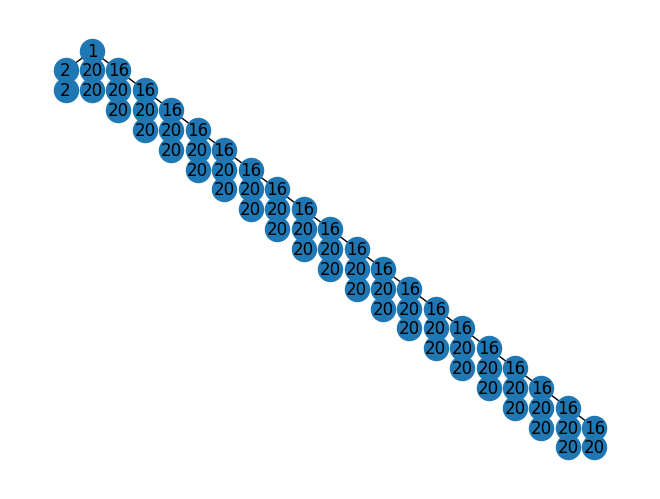

In [8]:
degree = 1

# Add the node that forms the root of the bath
topo = ntree("(1(2(2))(2))")

if(degree > 1):
    # If degree > 1, encode bath using a Tree Tensor Network (TTN)
    ntreeBuilder.mlmctdh_subtree(topo()[1], mode_dims, degree, chi)

else:
    # If degree == 1, encode bath using Matrix Product State (MPS, simplest case of a TTN,
    # initialised in an optimal way)
    ntreeBuilder.mps_subtree(topo()[1], mode_dims, chi, nbose)

# Optimise geometry of the TTN
ntreeBuilder.sanitise(topo)
print(topo)

visualise_tree(topo)

**Initialise Tree Tensor Network**

The Tree Tensor Network (TTN) is created as a `ttn` object with network geometry specified by `topo`, and subsequently initialised in a $|0\rangle$ state in all modes.

The Hamiltonian, that was previously initialised as a sum (`SOP`) of site operators (`sOP`), now is set up as a sparse Tree Tensor Network Operator, informed with the network geometry contained in `sysinf`. This is done using `sop_operator`. For a detailed guide on constructing Hamiltonians, read the [tutorial on operator generation](files/../operator_generation.ipynb).

In [28]:
# Create TTN using topology calculated above
A = ttn(topo)

# Initialise all modes in |0> state
A.set_state([0 for i in range(Nb+1)])

# Initialise Hamiltonian as sparse TTNO (TTN Operator)
# The parameter compress = true implements hierarchical form
h = sop_operator(H, A, sysinf, identity_opt=True, compress=True)

**Evaluation**

To obtain the dynamical results, it is necessary to define and prepare the operator that will be evaluated. The function `matrix_element` (see [matrix_element.hpp](files/../../python/ttns/observables/matrix_element.hpp) for reference) prepares the engine that will be used to calculate the expectation value of the operator of interest. An example of use can be seen inside the time-evolution loop (below).

The operator to evaluate is set up as a global site operator `site_operator`. It is initialised as a `sOP` (a _"site OPerator"_), and informed with the network topology contained in `sysinf`. A `site_operator` is different from a `sOP` because the former is a global operator that can interact with the TTN. For more information on these operators, read the [tutorial on operator generation](files/../operator_generation.ipynb).

In [29]:
# Engine to evaluate matrix elements
mel = matrix_element(A)

# Operator to evaluate
op = site_operator(sOP("sz", 0), sysinf)

**Time evolution**

The time evolution is performed using the TDVP algorithm (the _"Time Dependent Variational Principle"_; for more information see [SciPost Phys. Lect. Notes 7 (2019)](https://scipost.org/SciPostPhysLectNotes.7)). The function `tdvp()` creates the TDVP engine and specifies the dimenison of the Krylov subspace to use in the evolution. The `sweep.coefficient` determines the kind of time evolution: in the example below, it is complex evolution (`1.0j`), going forward in time (`-1.0j`).

The toggle `sweep.use_time_dependent_hamiltonian` updates the Hamiltonian during the time evolution, using the class `func_class` defined above for the interaction picture Hamiltonian. This can be though of as turning on / off the time-dependence of the Hamiltonian.

The desired expectation value is evaluated using `mel` (recall `mel = matrix_element(A)`, it is the engine for the matrix-element evaluation), and stored in vector of results `res`. Every 100 steps, the value of `res` is saved in a file of name `ofname`, specified in the simulation parameters above.

In [ ]:
# Initialise TDVP engine
sweep = tdvp(A, h, krylov_dim = 12)
sweep.dt = dt

# Specify complex, forward time evolution
sweep.coefficient = -1.0j

# Turn time-dependence on
if(geom == 'ipchain'):
    sweep.use_time_dependent_hamiltonian = True

# Vector to store result
res = np.zeros(nstep+1)

# Evaluate result before time evolution
res[0] = np.real(mel(op, A, A))

# TDVP loop
for i in range(nstep):
    # TDVP step
    t1 = time.time()
    sweep.step(A, h)
    t2 = time.time()
    
    # Evaluate result after evolution step
    res[i+1] = np.real(mel(op, A, A))

    # Print step
    print((i+1)*dt, t2-t1, res[i+1], mel(A))
    sys.stdout.flush()

    # Save the evolution result every 100 steps
    if(i % 100 == 0):
        h5 = h5py.File(fname, 'w')
        h5.create_dataset('t', data=(np.arange(nstep+1)*dt))
        h5.create_dataset('Sz', data=res)
        h5.close()

# Save final result of evolution
h5 = h5py.File(fname, 'w')
h5.create_dataset('t', data=(np.arange(nstep+1)*dt))
h5.create_dataset('Sz', data=res)
h5.close()

0.005 53.56034994125366 0.4999999999999975 0.999999999999995
